# Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
import sklearn

# Read dataset

In [2]:
# from torch.utils.data import Dataset
# from torch.utils.data import DataLoader

# class MLPDataset(Dataset):
#     def __init__(self, csv_file):
#         self.data = pd.read_csv(csv_file)
#     def __len__(self):
#         return len(self.data)
#     def __getitem__(self, idx):
#         feature = self.data.iloc[idx, 0:-1]
#         label = self.data.iloc[idx, -1]
#         return feature, label

data_train = pd.DataFrame(np.fromfile('data_train.dat', dtype=np.float32).reshape((-1, 824)))
data_val = pd.DataFrame(np.fromfile('data_val.dat', dtype=np.float32).reshape((-1, 824)))
data_test = pd.DataFrame(np.fromfile('data_test.dat', dtype=np.float32).reshape((-1, 824)))
X_training = data_train.iloc[:, 0:-1]
y_training = data_train.iloc[:, -1]
X_val = data_val.iloc[:, 0:-1]
y_val = data_val.iloc[:, -1]
X_test = data_test.iloc[:, 0:-1]
y_test = data_test.iloc[:, -1]
print(X_training.shape, X_val.shape, X_test.shape)
print(y_training.shape, y_val.shape, y_test.shape)

(4474020, 823) (552969, 823) (558555, 823)
(4474020,) (552969,) (558555,)


# MLP regression model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from tqdm import tqdm
import os
from torch.utils.data import Dataset, DataLoader

## Model define

In [4]:
class MLP(nn.Module): 
    '''
    Multilayer Perceptron for regression.
    '''
    def __init__(self, width, active_func):
        super().__init__() 
        torch.manual_seed(0) #setseed

        layer_list = []
        layer_list.append(nn.Linear(823, pow(2,width))) #expand to 2^width features
        layer_list.append(active_func) #tuned by given

        width_lay = width
        for i in range(6,width):
            layer_list.append(nn.Linear(pow(2,width_lay), pow(2,width_lay-1)))
            layer_list.append(active_func)
            width_lay -= 1
        layer_list.append(nn.Linear(64, 1))  # regression output
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.layers(x)

## Define utils functions

In [17]:
# trainer class
class Trainer:
    """Main class for model training"""
    
    def __init__(
        self,
        model,
        n_epochs,
        data_size,
        X_training,
        y_training,
        X_val,
        y_val,
        loss_func,
        checkpoint_frequency,
        model_dir,
        optimizer,
        batch_size,
        device,
        model_name,
    ):  
        self.net = model
        self.n_epochs = n_epochs
        self.data_size = data_size
        self.X_training = X_training
        self.y_training = y_training
        self.X_val = X_val
        self.y_val = y_val
        self.loss_func = loss_func
        self.checkpoint_frequency = checkpoint_frequency
        self.model_dir = model_dir
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.device = device
        self.model_name = model_name
        self.loss = {"train": [], "val": []}
        self.net.to(self.device)

    def fit_and_evaluate(self):
        '''
        Fits the neural network using the given optimizer, loss function, training set
        Returns:
            train_epoch_loss, test_epoch_loss: two arrays of length n_epochs+1,
            containing the mean loss at the beginning of training and after each epoch
        '''
        # load data
        training_p = self._torch_datap(self.X_training.iloc[0:self.data_size,:], self.y_training.iloc[0:self.data_size])
        valid_p = self._torch_datap(self.X_val, self.y_val)
    
        # Prepare data
        train_dl = torch.utils.data.DataLoader(training_p, self.batch_size, pin_memory=True)       
        val_dl = torch.utils.data.DataLoader(valid_p, self.batch_size, pin_memory=True)

        self.train_losses = []
        self.val_losses = []

        # Compute the loss on the training and validation sets at the start,
        self.net.eval()
        with torch.no_grad():
            self.train_losses.append(self._epoch_loss(train_dl))
            self.val_losses.append(self._epoch_loss(val_dl))
            
        # Train the network for n_epochs, storing the training and validation losses after every epoch.
        for epoch in tqdm(range(self.n_epochs)):
            #training
            self.net.train()
            for iteration, (xb, yb) in enumerate(train_dl):
                self._train_batch(xb.to(self.device), yb.to(self.device))
            #testing
            self.net.eval()
            with torch.no_grad():
                self.train_losses.append(self._epoch_loss(train_dl))
                self.val_losses.append(self._epoch_loss(val_dl))

            if self.checkpoint_frequency:
                self._save_checkpoint(epoch)
            
        return self.train_losses, self.val_losses

    def _torch_datap(self, feature_col, label): 
        feature_t = torch.tensor(feature_col.values, dtype=torch.float)
        label_t = torch.tensor(label.values, dtype=torch.float)
        datap = torch.utils.data.TensorDataset(feature_t, label_t)
        return datap

    def _train_batch(self, xb, yb):
        ''' 
        @param xb: a batch of the training data to input to the model
        @param yb: a batch of the training labels to input to the model
        '''
        # Zero the gradients
        self.optimizer.zero_grad()  
        # Perform forward pass
        yi = self.net(xb)
        # Compute loss
        loss = self.loss_func(yi, yb) 
        # Perform backward pass
        loss.backward()
        # Perform optimization
        self.optimizer.step()

    def _epoch_loss(self, data_loader):
        ''' Computes the average loss of the model on the entire dataset
        @param data_loader: The DataLoader which loads minibatches of the dataset
        @return The network's average loss over the dataset.
        '''
        total_examples = 0
        losses = []
        for X, Y in data_loader:
            total_examples += len(X)
            losses.append(self.loss_func(self.net(X.to(self.device)), Y.to(self.device)).item() * len(X)) # Compute total loss for batch
        return torch.tensor(losses).sum() / total_examples
    
    def _save_checkpoint(self, epoch):
        """Save model checkpoint to `self.model_dir` directory"""
        if epoch % self.checkpoint_frequency == 0:
            check_path = "/checkpoint_{}.pt".format(str(epoch).zfill(2))
            check_path = self.model_dir + self.model_name + check_path
            torch.save({
                'epoch': epoch,
                'model_state_dict': self.net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': [self.train_losses, self.val_losses],
                }, check_path)

## Hyper-para tuning

In [ ]:
# width_arry = np.array([10, 11, 12])
# act_array = np.array([nn.ReLU(), nn.Sigmoid()])
# loss_array = np.array([nn.L1Loss(), nn.MSELoss()])
# lr_array = np.array([0.001, 0.005, 0.05])
# opt_array = np.array(["Adam", "SGD"])

### test module

In [6]:
# para initialize
data_size = 100
batch_size = 10
n_epochs = 3
checkpoint_frequency = 1
model_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


# hyper-para tuning
width_arry = np.array([10, 11, 12])
act_array = np.array([nn.ReLU(), nn.Sigmoid()])
loss_array = np.array([nn.L1Loss(), nn.MSELoss()])
lr_array = np.array([0.001, 0.005, 0.05])
opt_array = np.array(["Adam", "SGD"])

# initialize model for tuning width
w=10
model = MLP(width = w, active_func = nn.ReLU())
# create folder ==================================
model_name = ('/width_%s'%w)
path_dir = model_dir + model_name
print(path_dir)
if not os.path.exists(path_dir):
    os.mkdir(path_dir)
loss_func = nn.L1Loss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
trainer = Trainer(
    model,
    n_epochs,
    data_size,
    X_training,
    y_training,
    X_val.iloc[0:data_size,:],
    y_val.iloc[0:data_size],
    loss_func,
    checkpoint_frequency,
    model_dir,
    optimizer,
    batch_size,
    device,
    model_name,
    )
train_losses, val_losses = trainer.fit_and_evaluate()

/home/hkhuang3/Documents/coding_general/cindy/width_10


/home/hkhuang3/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/hkhuang3/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:03<00:00,  1.21s/it]


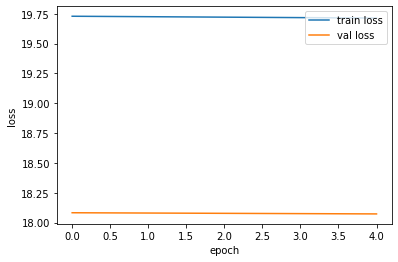

In [7]:
# plotting outcomes
epoch = torch.linspace(0,n_epochs+1,len(train_losses))
plt.plot(epoch, train_losses)
plt.plot(epoch, val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss', 'val loss'],loc='upper right')
plt.show()

### Width

100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [22:05<00:00, 441.92s/it]


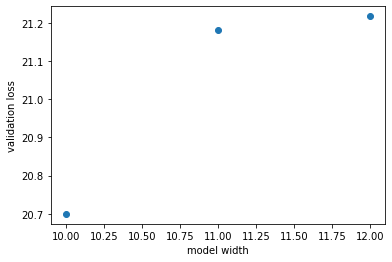

In [15]:
# para initialize
data_size = 100000
batch_size = 10
n_epochs = 3
checkpoint_frequency = 1
model_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


# hyper-para tuning
width_array = np.array([10, 11, 12])
active_func = nn.ReLU()
loss_func = nn.L1Loss()
learning_rate = 0.005

# initialize model for tuning width
model_loss = []
for w in range(width_array.shape[0]):
    model = MLP(width = width_array[w], active_func = active_func)
    model_name = ('/width_%s'% width_array[w])
    path_dir = model_dir + model_name
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    trainer = Trainer(
        model,
        n_epochs,
        data_size,
        X_training,
        y_training,
        X_val,
        y_val,
        loss_func,
        checkpoint_frequency,
        model_dir,
        optimizer,
        batch_size,
        device,
        model_name,
        )
    train_losses, val_losses = trainer.fit_and_evaluate()
    model_loss.append(np.array(val_losses).min())
    
plt.plot(width_array, model_loss, 'o')
plt.xlabel('model width')
plt.ylabel('validation loss')
plt.show()

### Activation layer

/home/hkhuang3/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/hkhuang3/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [18:16<00:00, 365.36s/it]


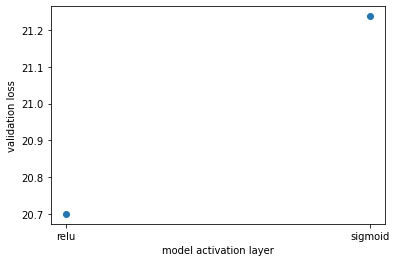

In [6]:
# para initialize
data_size = 100000
batch_size = 10
n_epochs = 3
checkpoint_frequency = 1
model_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


# hyper-para tuning
width = 10
act_array = np.array([nn.ReLU(), nn.Sigmoid()])
loss_func = nn.L1Loss()
learning_rate = 0.005

# initialize model for tuning activation function
model_loss = []
act_name = np.array(['relu', 'sigmoid'])
for a in range(act_array.shape[0]):
    model = MLP(width = width, active_func = act_array[a])
    model_name = ('/act_%s'% act_name[a])
    path_dir = model_dir + model_name
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    trainer = Trainer(
        model,
        n_epochs,
        data_size,
        X_training,
        y_training,
        X_val,
        y_val,
        loss_func,
        checkpoint_frequency,
        model_dir,
        optimizer,
        batch_size,
        device,
        model_name,
        )
    train_losses, val_losses = trainer.fit_and_evaluate()
    model_loss.append(np.array(val_losses).min())
    
plt.plot(act_name, model_loss, 'o')
plt.xlabel('model activation layer')
plt.ylabel('validation loss')
plt.show()

### loss function

/home/hkhuang3/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
Traceback (most recent call last):
  File "/software/python-3.10.0/lib/python3.10/multiprocessing/queues.py", line 251, in _feed
    send_bytes(obj)
  File "/software/python-3.10.0/lib/python3.10/multiprocessing/connection.py", line 205, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/software/python-3.10.0/lib/python3.10/multiprocessing/connection.py", line 416, in _send_bytes
    self._send(header + buf)
  File "/software/python-3.10.0/lib/python3.10/multiprocessing/connection.py", line 373, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File

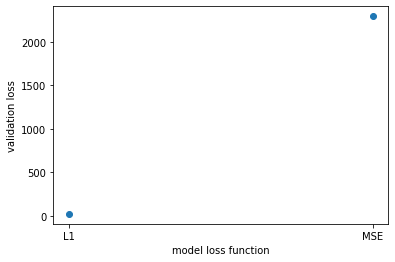

In [19]:
# para initialize
data_size = 100000
batch_size = 200
n_epochs = 3
checkpoint_frequency = 1
model_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


# hyper-para tuning
width = 10
active_func = nn.ReLU()
loss_array = np.array([nn.L1Loss(), nn.MSELoss()])
learning_rate = 0.005

# initialize model for tuning loss function
model_loss = []
loss_name = np.array(['L1', 'MSE'])
for l in range(loss_array.shape[0]):
    model = MLP(width = width, active_func = active_func)
    model_name = ('/loss_%s'% loss_name[l])
    path_dir = model_dir + model_name
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    loss_func = loss_array[l]
    trainer = Trainer(
        model,
        n_epochs,
        data_size,
        X_training,
        y_training,
        X_val,
        y_val,
        loss_func,
        checkpoint_frequency,
        model_dir,
        optimizer,
        batch_size,
        device,
        model_name,
        )
    train_losses, val_losses = trainer.fit_and_evaluate()
    model_loss.append(np.array(val_losses).min())
    
plt.plot(loss_name, model_loss, 'o')
plt.xlabel('model loss function')
plt.ylabel('validation loss')
plt.show()

### learning rate

100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:30<00:00, 10.10s/it]


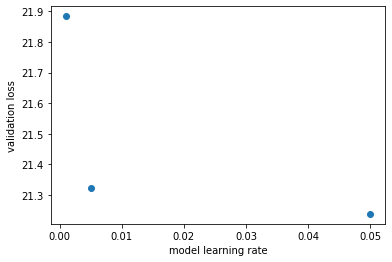

In [20]:
# para initialize
data_size = 100000
batch_size = 200
n_epochs = 3
checkpoint_frequency = 1
model_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


# hyper-para tuning
width = 10
active_func = nn.ReLU()
loss_func = nn.L1Loss()
lr_array = np.array([0.001, 0.005, 0.05])

# initialize model for tuning learning rate
model_loss = []
for r in range(lr_array.shape[0]):
    model = MLP(width = width, active_func = active_func)
    learning_rate = lr_array[r]
    model_name = ('/lr_%s'% learning_rate)
    path_dir = model_dir + model_name
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    trainer = Trainer(
        model,
        n_epochs,
        data_size,
        X_training,
        y_training,
        X_val,
        y_val,
        loss_func,
        checkpoint_frequency,
        model_dir,
        optimizer,
        batch_size,
        device,
        model_name,
        )
    train_losses, val_losses = trainer.fit_and_evaluate()
    model_loss.append(np.array(val_losses).min())
    
plt.plot(lr_array, model_loss, 'o')
plt.xlabel('model learning rate')
plt.ylabel('validation loss')
plt.show()

### optimizer

100%|██████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:42<00:00, 14.18s/it]


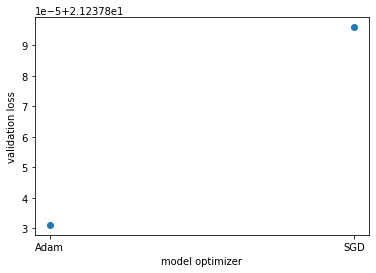

In [21]:
# para initialize
data_size = 100000
batch_size = 100
n_epochs = 3
checkpoint_frequency = 1
model_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 


# hyper-para tuning
width = 10
active_func = nn.ReLU()
loss_func = nn.L1Loss()
learning_rate = 0.005
opt_array = np.array(["Adam", "SGD"])

# initialize model for tuning optimizer
model_loss = []
for o in range(opt_array.shape[0]):
    model = MLP(width = width, active_func = active_func)
    model_name = ('/opt_%s'% opt_array[o])
    path_dir = model_dir + model_name
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    if o==0:
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    trainer = Trainer(
        model,
        n_epochs,
        data_size,
        X_training,
        y_training,
        X_val,
        y_val,
        loss_func,
        checkpoint_frequency,
        model_dir,
        optimizer,
        batch_size,
        device,
        model_name,
        )
    train_losses, val_losses = trainer.fit_and_evaluate()
    model_loss.append(np.array(val_losses).min())
    
plt.plot(opt_array, model_loss, 'o')
plt.xlabel('model optimizer')
plt.ylabel('validation loss')
plt.show()

In [ ]:
# https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [ ]:
'''TODO: load model, test model performance'''
'''Test: dimensional reduction affect?'''